In [7]:
from __future__ import division
import warnings; warnings.simplefilter('ignore') #for PCoA warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from DEICODE import untangle,fetch
from IPython.core.display import HTML

 Sponges (case study)

 A comprehensive analysis of microbial symbiont communities associated with 82 species from the phylum Porifera

 P.I.  Torsten Thomas (University of New South Wales)
 [Data and Source](https://qiita.ucsd.edu/study/description/10346)

First we import the .biom OTU table and tab delimited mapping file (qiime style).

In [9]:
map_file='data/benchmarking/Thomas_sponge_communities.txt' #import metadata
in_biom='data/benchmarking/Thomas_sponge_communities.biom' #import biom file
filter_count=200 # filtering could for biom file (useful for large datasets) 
otutabledf,mappingdf,taxnames=fetch.dfimport(in_biom,map_file,filter_count)

Next we will run supervised machine learning this will help us identify biologically relevant trends in the data quickly

In [10]:
# The main input is just the otu table and the mapping data. 
# complete will determine if you do completion (iteration is the number of iterations for the completion)
spongescores,sponge_low_rank_data=untangle.machine_learning(otutabledf,mappingdf.T,complete=True,iteration=62,mean_count=1,addtofilter=['adult'])

 Now we can visualize the output of the machine learning.

 The cross-validation scores give you a metric of how well each mapping category (i.e. metadata column) correlates to the taxonomic patterns in your data. For example here we see that life stage correlates the best with taxonomic trends.

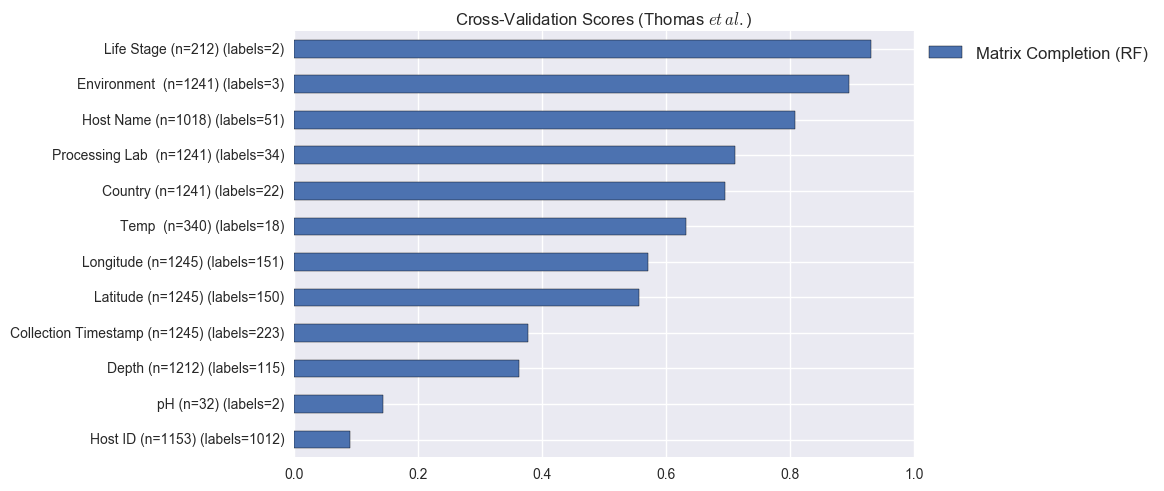

In [21]:
fig, (ax1) = plt.subplots(ncols=1, nrows=1)
spongescores.columns=['Matrix Completion (RF)']
spongescores.sort_values(['Matrix Completion (RF)'], ascending = [True], inplace = True)
#rename a few
spongescores.plot(kind='barh',title='Cross-Validation Scores (Thomas $et \, al.$)',xlim=(0,1),ax=ax1)
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles[::-1], labels[::-1],loc=2,prop={'size':12}, bbox_to_anchor=(1.0, 1.0))
ax1.set_ylabel('')
plt.show()

 Extract OTUs (features) that separate sponges across life stages.

 Now that we know from the cross-validation scores that life stage is an important category we would like to find out what pattern of OTUs best explain this variation.  Here we plot the taxonomic pattern that the machine learning algorithm found to be most predictive for the sponge sample's life stage. The taxonomy labels are the lowest classification assigned with the phylum in parenthesis.

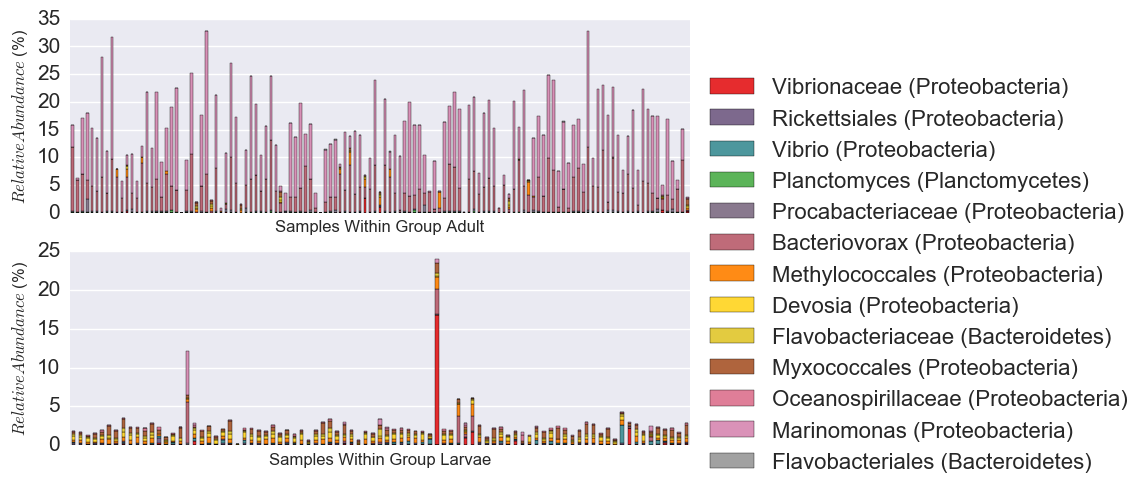

In [12]:
#get important features
n=13#this will be the number of OTUs that are in the figure 
niche='Life Stage'#this will determine which mapping catagory to use
sfotus,sfmappingdf=fetch.matchtable(otutabledf,mappingdf.T[~mappingdf.T[niche].isin(['Unknown','adult'])].T)
important_otus=untangle.features_ml(sfotus,sfmappingdf.T,niche,complete=True,iteration=100)
#plot
fig=untangle.feature_vis(sfotus,sfmappingdf,list(important_otus.index[:n]),niche,taxnames)
plt.show()

 Here we find that the OTUs that best differentiate the samples between adult sponges and larvae are mostly in the phylum Proteobacteria. We can see that the Proteobacteria Marinomonas and Oceanospirillaceae are more abundant in adult sponges, while the larvae sponges have a diverse group of Proteobacteria and Chloroflexi that differentiate them.

 Now we can visualize the clustering in clr-PCA and extract variant OTUs along the axis for life stage.

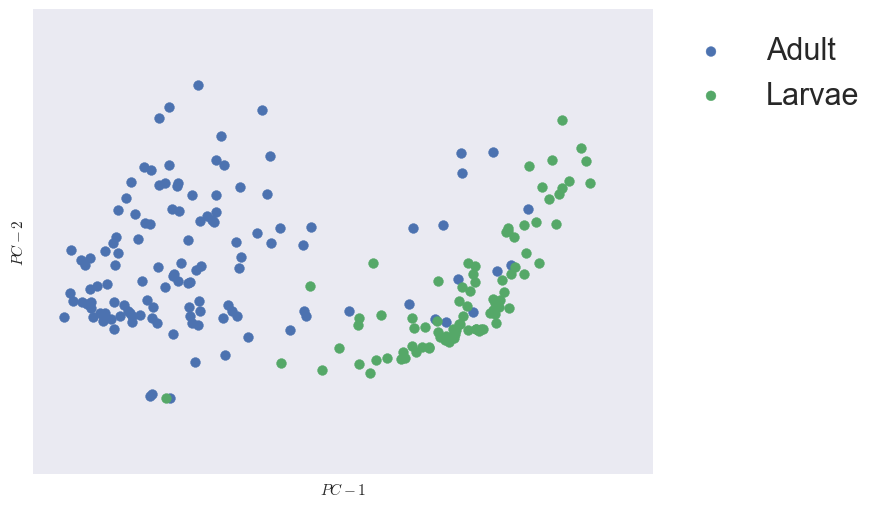

In [13]:
#compare to PCoA
fig,OTUweightsPC1,OTUweightsPC2=untangle.reduce_plot(sfotus,sfmappingdf,niche,min_val=1)
plt.show()

 The clearest separation between adult and larvae is on acis PC-1. We can now identify bacteria that cause variance along this axis. In other words we can recover information about features from PCA eigenvectors.

 The principal components are a linear combination of original features in N dimensional space.

 $ PC^{j} = \beta_{1}^{j}X_{1} +  \beta_{2}^{j}X_{2} + ... + \beta_{N}^{j}X_{N} $

 Where $\beta_{N}^{j}$ are weights and $X_{N}$ is the original variables

 Therefore the coefficients are the transform of an identity matrix of shape X

 Each column of the transformed coefficient matrix are the coefficients $\beta_{N}^{j}$ weights pertaining to each principal component $ PC^{j}$. 

 In other words we can examine the weights on each OTU (or bacteria) that best explain the variance of each axis in our PCA graph. 

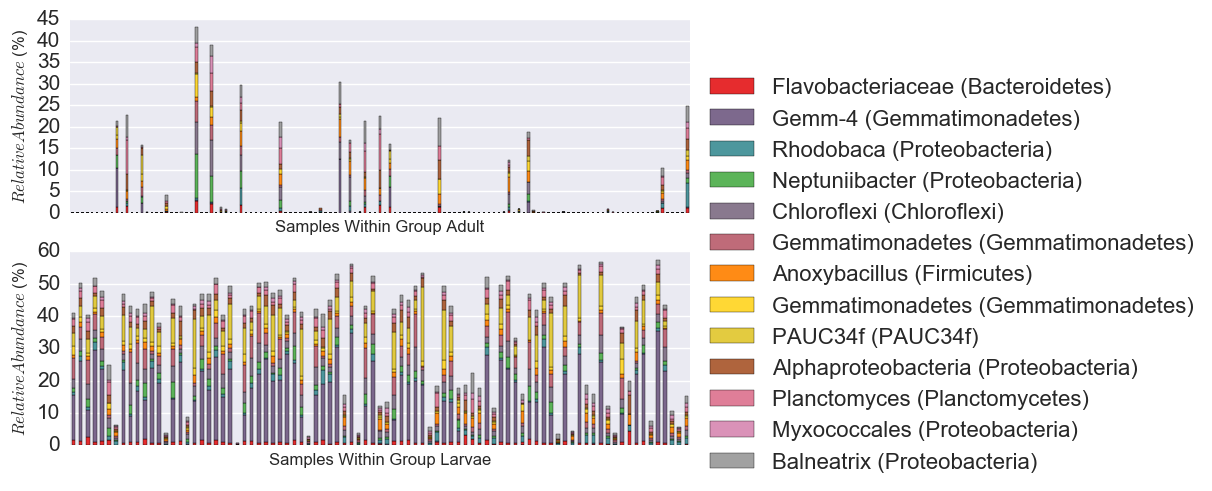

In [14]:
#plot 
n=13 #this will tell the command how many bacteria to plot
fig=untangle.feature_vis(sfotus,sfmappingdf,list(OTUweightsPC1.index[:n]),niche,taxnames)
plt.show()

For example here we find that the OTUs that best differentiate adult from larvae sponges are mostly in the phylum Gemmatimonadete and Proteobacteria.

[Next Example](https://github.com/cjm007/DEICODE/blob/master/Examples/infant_biom.ipynb)